In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import wfdb
import csv
import os
from scipy.signal import butter, filtfilt
import scipy
import emd
import time
from scipy.interpolate import CubicSpline
from sklearn.preprocessing import MinMaxScaler

import scipy
import time
from scipy.signal import medfilt
from scipy.signal import firwin, lfilter

from utils import print_signal_qrs, print_signal, calcul_f1, perf

In [ ]:
def low_pass_filter(data, cutoff_frequency, sample_rate):
    normalized_cutoff = cutoff_frequency / (0.5 * sample_rate)
    b, a = signal.butter(N=1, Wn=normalized_cutoff, btype='low', analog=False)
    filtered_data = signal.filtfilt(b, a, data)
    
    return filtered_data

In [32]:
def decompose_signal_into_imfs(signal, nb):
    imf = emd.sift.sift(signal)
    imfs = np.array(imf).T[:nb]    
    return imfs

def moving_window_integration(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

def low_pass_filter(data, cutoff_frequency, fs, order):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_frequency / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

def nonlinear_transform(x):
    y = np.zeros_like(x)
    for n in range(2, len(x)):
        if np.sign(x[n]) == np.sign(x[n-1]) == np.sign(x[n-2]):
            y[n] = abs(x[n] * x[n-1] * x[n-2])
        else:
            y[n] = 0
    return y

def normalize_data(data):
    #return data
    max_value =  np.max(data) * 0.1 
    normalized_signal = np.where(data >= max_value, 1, data / max_value)
    return normalized_signal

def remove_baseline_wander(signal, fs):
    order = 5
    nyquist = 0.5 * fs
    normal_cutoff = 1 / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal
    
#detect_r_positions(final_ecg, height=np.max(final_ecg) * 0.5, distance=fs * 0.2)

In [33]:
def qrs_localization(h, fs, seuil):
    i = np.argmax(h[:300])
    list_peaks = [i]
    limite_suite = int(fs*0.12)
    previous_val = h[i+limite_suite]
    last_peak = i
    i = i + limite_suite
    while i < len(h):
        if h[i] > previous_val:
            peakos = i + np.argmax(h[i:i+int(fs*0.4)])
            if last_peak != list_peaks[-1]:
                if peakos - last_peak < int(fs*0.3):
                    list_peaks.append(peakos)
                else:
                    list_peaks.append(last_peak)
                
            last_peak = peakos
            i = peakos + limite_suite

        if i < len(h):
            previous_val = h[i]
        i += 1

    return list_peaks

In [34]:
df = pd.read_csv('data_csv/mit_bih_Arrhythmia/207.csv') #207
ecg_signal = np.array(df["MLII"], dtype=np.float32)#[:1000]
fs = 360  # Example sampling frequency
QRS = df["labels"].dropna().astype(int).tolist()

In [35]:
"""M = 30
mini = 0
maxi = 1200
print_signal(ecg_signal[mini:maxi])
no_baseline = remove_baseline_wander(ecg_signal, fs)
print_signal(no_baseline[mini:maxi])
IMFs = decompose_signal_into_imfs(no_baseline, 3)
print_signal(IMFs[0][mini:maxi], "0")
print_signal(IMFs[1][mini:maxi], "1")
print_signal(IMFs[2][mini:maxi], "2")
sntks = [moving_window_integration(nonlinear_transform(imf), M) for imf in IMFs]
z_n = np.sum(sntks, axis=0)
print_signal(z_n[mini:maxi])
z_filtered = low_pass_filter(z_n, 2 , fs)
print_signal(z_filtered[mini:maxi])
final_ecg = z_filtered # normalize_data(z_filtered)"""

'M = 30\nmini = 0\nmaxi = 1200\nprint_signal(ecg_signal[mini:maxi])\nno_baseline = remove_baseline_wander(ecg_signal, fs)\nprint_signal(no_baseline[mini:maxi])\nIMFs = decompose_signal_into_imfs(no_baseline, 3)\nprint_signal(IMFs[0][mini:maxi], "0")\nprint_signal(IMFs[1][mini:maxi], "1")\nprint_signal(IMFs[2][mini:maxi], "2")\nsntks = [moving_window_integration(nonlinear_transform(imf), M) for imf in IMFs]\nz_n = np.sum(sntks, axis=0)\nprint_signal(z_n[mini:maxi])\nz_filtered = low_pass_filter(z_n, 2 , fs)\nprint_signal(z_filtered[mini:maxi])\nfinal_ecg = z_filtered # normalize_data(z_filtered)'

In [41]:
M = 30
no_baseline = remove_baseline_wander(ecg_signal, fs)
IMFs = decompose_signal_into_imfs(no_baseline, 2)
sntks = [moving_window_integration(nonlinear_transform(imf), M) for imf in IMFs]
z_n = np.sum(sntks, axis=0)
final_ecg = low_pass_filter(z_n, 2 , fs, 2)
r_positions = qrs_localization(final_ecg, fs, 0.01)
perfo = perf(QRS, r_positions, 36)
perfo

(1987, 614, 616, 0.7636433512682552)

In [38]:
M = 30
no_baseline = remove_baseline_wander(ecg_signal, fs)
IMFs = decompose_signal_into_imfs(no_baseline, 3)
sntks = [moving_window_integration(nonlinear_transform(imf), M) for imf in IMFs]
z_n = np.sum(sntks, axis=0)
perf_df = pd.DataFrame()

for order in range(1,6):
    for cutoff in np.arange(0.5, 50, 0.5):
        final_ecg = low_pass_filter(z_n, cutoff , fs, order)
        r_positions = qrs_localization(final_ecg, fs, 0.01)
        perfo = perf(QRS, r_positions, 36)
        
        perf_df = pd.concat([perf_df, pd.DataFrame({"order" :order, 
                                                    "cutoff": cutoff, 
                                                    "TP": perfo[0],
                                                    "FP": perfo[1],
                                                    "FN": perfo[2],
                                                    "F1": perfo[3],
                                                   }, 
                                                   index=[0])], 
                            ignore_index=True)
        
perf_df.sort_values("F1", ascending = False, inplace = True)

In [39]:
perf_df

,order,cutoff,TP,FP,FN,F1
396,5,0.5,500,3231,3235,0.133941
297,4,0.5,535,3176,3180,0.144088
198,3,0.5,628,3009,3013,0.172575
134,2,18.0,1194,3469,3469,0.256058
133,2,17.5,1197,3465,3465,0.256757
...,...,...,...,...,...,...
2,1,1.5,1780,917,923,0.659259
5,1,3.0,1808,930,934,0.659854
4,1,2.5,1798,922,926,0.660544
3,1,2.0,1801,897,903,0.666790


In [ ]:
(1847,
 866,
 872,

signal de longueur: 650000


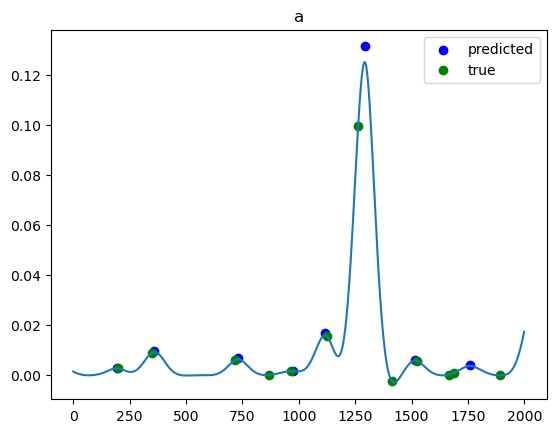

In [13]:
print_signal_qrs(final_ecg, r_positions, QRS, mini = 13000, maxi = 15000)

In [37]:
perf(QRS,r_positions, 50, True)

(1947,
 568,
 580,
 0.7723125743752479,
 [array([ 9, 50, 76], dtype=int64),
  array([719], dtype=int64),
  array([1465], dtype=int64),
  array([2187], dtype=int64),
  array([2984], dtype=int64),
  array([3754], dtype=int64),
  array([4505], dtype=int64),
  array([5280], dtype=int64),
  array([6824], dtype=int64),
  array([7591], dtype=int64),
  array([8322], dtype=int64),
  array([9051], dtype=int64),
  array([9838], dtype=int64),
  array([10565], dtype=int64),
  array([11344], dtype=int64),
  array([12436], dtype=int64),
  array([12523], dtype=int64),
  array([13868], dtype=int64),
  array([14414], dtype=int64),
  array([14758], dtype=int64),
  array([14894], dtype=int64),
  array([15387], dtype=int64),
  array([15519], dtype=int64),
  array([15759], dtype=int64),
  array([15849], dtype=int64),
  array([15906], dtype=int64),
  array([16138], dtype=int64),
  array([16383], dtype=int64),
  array([16496], dtype=int64),
  array([16710], dtype=int64),
  array([16936], dtype=int64),
  array

In [35]:
diffos = np.diff(r_positions)
listos = []
i = 0
while i < len(diffos):
    
    if diffos[i] < 100:
        v1 = final_ecg[r_positions[i]]
        v2 = final_ecg[r_positions[i+1]]
        if v1 > v2:
            listos.append(r_positions[i])
        else:
            listos.append(r_positions[i+1])
        i += 2
    else:
        listos.append(r_positions[i])
        i += 1

signal de longueur: 650000


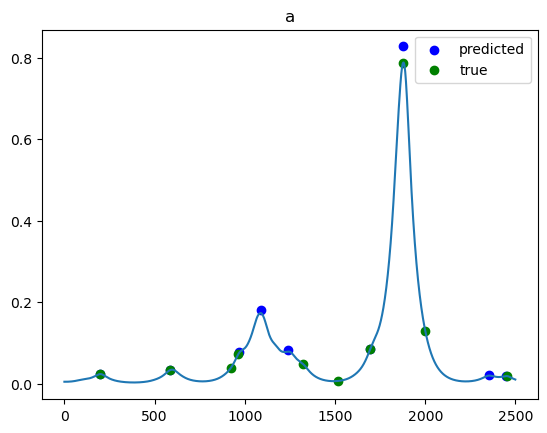

In [40]:
print_signal_qrs(final_ecg, r_positions, QRS, maxi = 11500, mini= 9000)

In [9]:
def qrs_localization(h, fs, seuil):
    i = np.argmax(h[:300])
    list_peaks = [i]
    limite_suite = int(fs*0.12)
    previous_val = h[i+limite_suite]
    last_peak = i
    i = i + limite_suite
    while i < len(h):
        if h[i] > previous_val:
            peakos = i + np.argmax(h[i:i+int(fs*0.4)])
            if last_peak != list_peaks[-1]:
                if peakos - last_peak < int(fs*0.3):
                    list_peaks.append(peakos)
                else:
                    list_peaks.append(last_peak)
                
            last_peak = peakos
            i = peakos + limite_suite

        if i < len(h):
            previous_val = h[i]
        i += 1

    return list_peaks

In [43]:
perf(QRS,r_positions, 36, True)

(32,
 1792,
 1796,
 0.017524644030668127,
 [array([23]),
  array([88]),
  array([157, 169, 170, 174, 175, 177, 177, 183, 183, 188, 189, 189, 190,
         190, 192, 195, 196, 198, 199, 199, 199, 199, 199, 199, 199, 199,
         199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199,
         199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199,
         199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199,
         199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199,
         199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199,
         199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199,
         199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199,
         199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199,
         199, 199, 199, 199, 199, 199, 199]),
  array([442]),
  array([789]),
  array([1155]),
  array([1493]),
  array([1821]),
  array([2157]),
  array([2517]),
  array([2889]),
  array(

In [ ]:
1681,
 225,
 225

In [69]:
def qrs_localization(h, XX, fs):
    qrs_indices = []
    sous_groupe = []
    w = 1000
    threshold = XX
    A = int(fs//10)
    compteur = 0
    for i in range(len(h)):
        if compteur != 0:
            compteur -= 1
            continue
        #if i%w == 0 and i != 0:
        #    threshold = np.mean(h[i-(w//2):i+(w//2)]) #XX * max(h[i-(w//2):i+(w//2)])
        if h[i] >= threshold:
            sous_groupe.append(i)
        elif sous_groupe != [] and i - sous_groupe[-1] >= A: # 36 = valeur donnée dans l'article
            v = max([(x, h[x]) for x in sous_groupe], key=lambda x: x[1])[0]
            #v = int(np.mean(sous_groupe))
            qrs_indices.append(v)
            compteur = A
            sous_groupe = []
    if sous_groupe != []:
        #qrs_indices.append(int(np.mean(sous_groupe))) 
        qrs_indices.append(max([(x, h[x]) for x in sous_groupe], key=lambda x: x[1])[0])
    return qrs_indices

signal de longueur: 1000


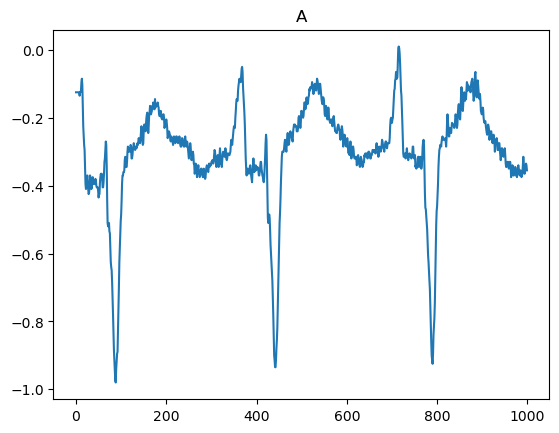

signal de longueur: 1000


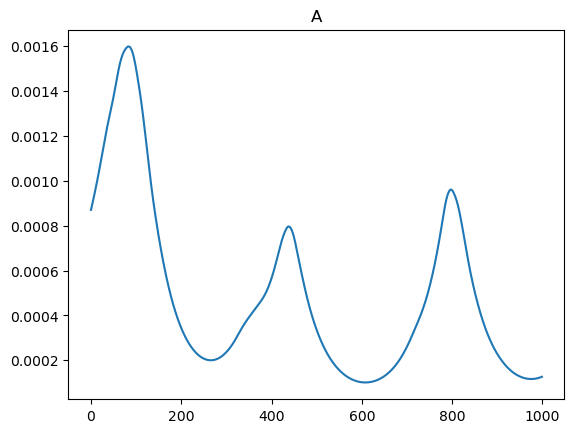

In [68]:
print_signal(final_ecg[:1000])

In [8]:
def decompose_signal_into_imfs(signal):
    emd = EMD()
    IMFs = emd.emd(signal)
    return IMFs[:3]

def select_imfs(IMFs, qrs_duration):
    threshold = 0.1  # Définissez votre propre seuil ici
    if qrs_duration < threshold:
        return IMFs[:2]
    else:
        return IMFs[:3]

def moving_window_integration(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

def low_pass_filter(data, cutoff_frequency, fs):
    order = 1
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_frequency / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

def detect_r_positions(signal, height=None, distance=None):
    peaks, _ = find_peaks(signal, height=height, distance=distance)
    return peaks

fs = 360
M = 36

IMFs = decompose_signal_into_imfs(ecg_signal)
#selected_IMFs = select_imfs(IMFs, qrs_duration=0.08)
print("IMFS")
sntks = [moving_window_integration(nonlinear_transform(imf), M) for imf in IMFs]
print("sntks")
z_n = np.sum(sntks, axis=0)
z_filtered = low_pass_filter(z_n, 1.0, fs)
print("z_filtered")
r_positions = detect_r_positions(z_filtered, height=np.max(z_filtered) * 0.5, distance=fs * 0.2)

KeyboardInterrupt: 

In [ ]:
perf(QRS, r_positions, 36)

In [ ]:
mini = 0
maxi = 1000
print_signal_qrs(cleaned_ecg[mini:maxi], 
                 [a - mini for a in qrs_indices if a < maxi and a > mini], 
                 [a - mini for a in QRS if a < maxi and a > mini], )

In [36]:
dataset = "mit_bih_Arrhythmia"

In [68]:
start = time.time()
best_F1 = 0
performance_EMD = pd.DataFrame()
data_folder = os.listdir(f"data_csv/{dataset}/")
data_folder.sort()
performance_EMD = pd.DataFrame()
for fichier in data_folder:
    df = pd.read_csv(f"data_csv/{dataset}/{fichier}")
    print(fichier)
    if "V1" not in df.columns:
        continue
    signal = np.array(df["V1"], dtype=np.float32)
    sampling_rate = 360
    QRS = df["labels"].dropna().tolist()
    #QRS = [int(R) for R in QRS if R <= max]

    r_peaks = full_emd(signal, sampling_rate) ###
    #r_peaks = [a + 36 for a in r_peaks]
    perf_temp = perf(QRS, r_peaks, 36)
    performance_EMD = pd.concat([performance_EMD, pd.DataFrame({"data" : fichier[:-4], "TP": perf_temp[0], "FP": perf_temp[1], "FN":perf_temp[2]}, index=[0])], ignore_index=True)
performance_EMD["Sensi"] = performance_EMD["TP"] / (performance_EMD["TP"] + performance_EMD["FN"])
performance_EMD["Specificity"] = performance_EMD["TP"] / (performance_EMD["TP"] + performance_EMD["FP"])
performance_EMD["f1_score"] = (2 * performance_EMD["TP"]) / (2 * performance_EMD["TP"] + performance_EMD["FN"] + performance_EMD["FP"])
performance_EMD.sort_values("f1_score", inplace = True)
end = time.time()
print(end - start)
start = time.time()

100.csv
101.csv
102.csv
103.csv
104.csv
105.csv
106.csv
107.csv
108.csv
109.csv
111.csv
112.csv
113.csv
114.csv
115.csv
116.csv
117.csv
118.csv
119.csv
121.csv
122.csv
123.csv
124.csv
200.csv
201.csv
202.csv
203.csv
205.csv
207.csv
208.csv
209.csv
210.csv
212.csv
213.csv
214.csv
215.csv
217.csv
219.csv
220.csv


C:\Users\Dieu\AppData\Local\Temp\ipykernel_9264\81424594.py:3: RuntimeWarning: divide by zero encountered in divide
  normalized_signal = np.where(signal >= max_value, 1, signal / max_value)
C:\Users\Dieu\AppData\Local\Temp\ipykernel_9264\81424594.py:3: RuntimeWarning: invalid value encountered in divide
  normalized_signal = np.where(signal >= max_value, 1, signal / max_value)
C:\Users\Dieu\AppData\Local\Temp\ipykernel_9264\81424594.py:40: RuntimeWarning: invalid value encountered in subtract
  result[window_size:] = result[window_size:] - result[:-window_size]


221.csv
222.csv
223.csv
228.csv
230.csv
231.csv
232.csv
233.csv
234.csv
177.2533655166626


In [319]:
performance_EMD.mean()

data           2352852330918045647736899141435540927021181872...
TP                                                    2282.73913
FP                                                     18.021739
FN                                                     66.804348
Sensi                                                   0.971753
Specificity                                             0.991634
f1_score                                                0.981108
dtype: object

In [375]:
df = pd.read_csv('data_csv/mit_bih_noise_stress/119e24.csv') #207
signal = np.array(df["MLII"], dtype=np.float32)
sampling_rate = 360
maxi = len(df)
mini = 0 #15000
signal = signal[mini:maxi]
QRS = df["labels"].dropna().tolist()
QRS = [int(R) - mini for R in QRS if R >= mini and R <= maxi]

signal de longueur: 1000


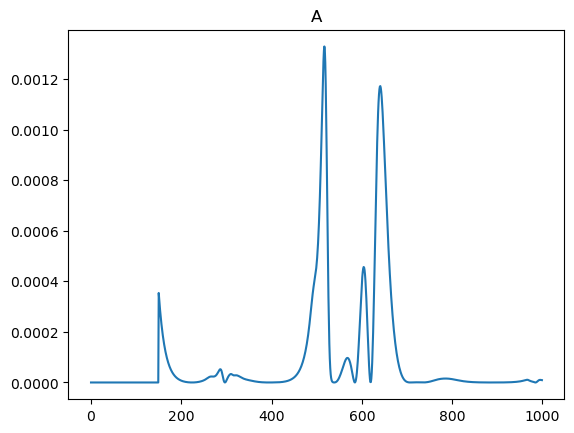

In [399]:
print_signal(filtered_signal[:1000])

In [404]:
signal_without_baseline =  baseline_wander_cancel(signal, sampling_rate)
#print_signal_qrs(signal_without_baseline[:WWW], "a", QRS2)
l = []
imfs = emd.sift.sift(signal_without_baseline)
for i in range(0, 3):
    imf = [t[i] for t in imfs]    
    transformed_signal = nonlinear_transform(imf)
    #transformed_signal = normalize_data(transformed_signal)
    #print_signal_qrs(transformed_signal[:WWW], 'A', QRS2)
    M = 10 # Nombre d'échantillons correspondant à la fenêtre d'intégration
    integrated_signal = integration(transformed_signal, M)
    #print_signal(integrated_signal, "integ")
    l.append(integrated_signal)
arr = np.array(l)
signal_end = arr.sum(axis=0)
filtered_signal, r_peaks = low_pass_filter_and_r_position(signal_end , sampling_rate, 0.01)
perf(QRS, r_peaks, 36)

(1265,
 103,
 829,
 [array([32]),
  array([309]),
  array([977]),
  array([2294]),
  array([4257]),
  array([7512]),
  array([7610]),
  array([8178]),
  array([8377]),
  array([8416]),
  array([8860]),
  array([9531]),
  array([9736]),
  array([9775]),
  array([10194]),
  array([10867]),
  array([11065]),
  array([11105]),
  array([11305]),
  array([12804]),
  array([12901]),
  array([12999]),
  array([13462]),
  array([13657]),
  array([14120]),
  array([14788]),
  array([14981]),
  array([15017]),
  array([15216]),
  array([15451]),
  array([16720]),
  array([17391]),
  array([17722]),
  array([18726]),
  array([19403]),
  array([19628]),
  array([20104]),
  array([20437]),
  array([20532]),
  array([21102]),
  array([21296]),
  array([21763]),
  array([21970]),
  array([22190]),
  array([22411]),
  array([25070]),
  array([27695]),
  array([29704]),
  array([29812]),
  array([30386]),
  array([31066]),
  array([31494]),
  array([31727]),
  array([41936]),
  array([42595]),
  array([

In [395]:
def normalize_data(data):
    max_value =  np.max(signal) * 0.7 
    normalized_signal = np.where(signal >= max_value, 1, signal / max_value)
    return normalized_signal

def baseline_wander_cancel(ecg_signal, sampling_rate):
    cutoff_freq = 1  # Fréquence de coupure à 1 Hz
    order = 5  # Ordre du filtre
    b, a = scipy.signal.butter(order, 
                         cutoff_freq / (sampling_rate / 2), 
                         'highpass', 
                         analog=False)
    ecghp = scipy.signal.lfilter(b, a, ecg_signal)
    return ecghp

def low_pass_filter_and_r_position(signal, sampling_rate, seuil):
    cutoff = 2
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff / nyquist
    b, a = butter(1, normal_cutoff, btype='low', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    derivative = np.diff(filtered_signal)
    derivative[:150] = 0
    derivative[-150:] = 0
    squared = derivative ** 2
    #squared = np.clip(squared, a_min=None, a_max=0.0001)
    #print_signal(squared[:20000], "squared", print_qrs = False)
    # np.mean(squared) * 3
    seuil = np.mean(squared) #* 3
    r_peaks = qrs_localization(squared, seuil, sampling_rate) # np.mean(squared)) 
    return squared, r_peaks

def nonlinear_transform(x):
    y = [0] * len(x)
    for n in range(2, len(x)):
        if (x[n] >= 0 and x[n-1] >= 0 and x[n-2] >= 0) or (x[n] <= 0 and x[n-1] <= 0 and x[n-2] <= 0):
            y[n] = abs(x[n] * x[n-1] * x[n-2])
    return y

def moving_window_integration(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

In [390]:
def qrs_localization(h, XX, fs):
    qrs_indices = []
    sous_groupe = []
    w = 1000
    threshold = GLOBAL_THRE #np.mean(h)*3 #XX # * max(h[:w]) #np.mean(h[:1000])#
    A = int(fs//10) * 2
    compteur = 0
    for i in range(len(h)):
        if compteur != 0:
            compteur -= 1
            continue
        #if i%w == 0 and i != 0:
        #    threshold = np.mean(h[i-(w//2):i+(w//2)]) #XX * max(h[i-(w//2):i+(w//2)])
        if h[i] >= threshold:
            sous_groupe.append(i)
        elif sous_groupe != [] and i - sous_groupe[-1] >= A: # 36 = valeur donnée dans l'article
            v = max([(x, h[x]) for x in sous_groupe], key=lambda x: x[1])[0]
            #v = int(np.mean(sous_groupe))
            qrs_indices.append(v)
            compteur = A //2
            sous_groupe = []
    if sous_groupe != []:
        #qrs_indices.append(int(np.mean(sous_groupe))) 
        qrs_indices.append(max([(x, h[x]) for x in sous_groupe], key=lambda x: x[1])[0])
    return qrs_indices

In [371]:
def regroup(peaks, thr):
    diff = peaks[1:]-peaks[:-1]
    gps = np.concatenate([[0], np.cumsum(diff>=thr)])
    temp = [peaks[gps==i] for i in range(gps[-1]+1)]
    max_sublist = []
    return [np.mean(sublist).astype(int) for sublist in temp]

def perf(labels, peaks, minmax):
    x = np.concatenate([np.array(labels), np.array(peaks)]) #list(set(QRS + r_peaks))
    x.sort()
    diff = x[1:]-x[:-1]
    gps = np.concatenate([[0], np.cumsum(diff>=minmax)])
    temp = [x[gps==i] for i in range(gps[-1]+1)]
    TP = 0
    FP = 0
    FN = 0
    list_F = []
    for sublist in temp:
        if len(sublist) == 2:
            TP += 1
        else:
            list_F.append(sublist)
            if sublist[0] in labels:
                FN += 1
            else:
                FP += 1
    return TP, FP, FN, list_F

def print_signal(signal, description= "A", print_qrs = False):
    print(f"signal de longueur: {len(signal)}")
    plt.figure()
    plt.plot(signal)
    if print_qrs:
        plt.scatter(QRS, [signal[i] for i in QRS], color='red')
    plt.title(label= description)
    plt.show()
    
def print_signal_qrs(signal, description, qrs):
    print(f"signal de longueur: {len(signal)}")
    plt.figure()
    plt.plot(signal)
    plt.scatter(qrs, [signal[i] for i in qrs], color='red')
    plt.title(label= description)
    plt.show()
    
def calcul_f1(TP, FP, FN):
    return (2 * TP) / (2 * TP + FN + FP)

def print_signal_qrs_c(signal, description, qrs, true):
    print(f"qrs = {qrs}")
    print(f"signal de longueur: {len(signal)}")
    plt.figure()
    plt.plot(signal)
    plt.plot([GLOBAL_THRE for i in range(len(signal))])
    plt.scatter(qrs, [signal[i] for i in qrs], color='red', label = 'predicted')
    plt.scatter(true, [signal[i] for i in true], color='blue', label = 'true')
    plt.title(label= description)
    plt.legend()
    plt.show()

signal de longueur: 1000


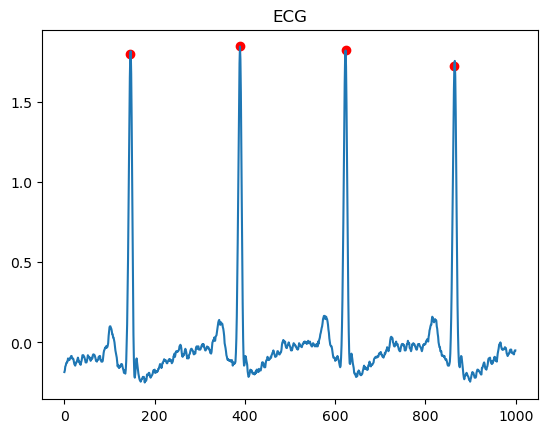

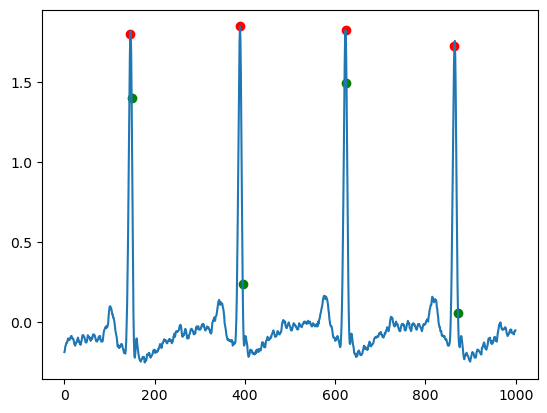

(4, 0, 0, [])

In [10]:
df = pd.read_csv('data_csv/mit_bih_Arrhythmia/234.csv') #207
signal = np.array(df["MLII"], dtype=np.float32)
sampling_rate = 360
maxi = 571000 #len(df)
mini = 570000
signal = signal[mini:maxi]
QRS = df["labels"].dropna().tolist()
QRS = [int(R)-mini for R in QRS if R >= mini and R <= maxi]
print_signal(signal, "ECG")
filter_s = baseline_wander_cancel(signal, sampling_rate)
#print_signal(filter, "filtered")
imfs = emd.sift.sift(filter_s)
r = np.array([])
tab_perf = []
for i in range(2):
    imf = [t[i] for t in imfs]
    #print_signal(imf, str(i))
    nl_t = nonlinear_transform(imf)
    #print_signal(nl_t, "non_lineare")
    inte = integration(nl_t, 2)
    m = np.mean(inte)
    #inte = [val if val <= m*3 else m*10 for val in inte]    
    #print_signal(inte, "inte")
    if r.size == 0:
        r = np.array([inte])
    else:
        r = np.add(r, inte)
r = r[0]
#print_signal(r.tolist(), "r")
sf, r_peaks = low_pass_filter_and_r_position(r, sampling_rate)
#r_peaks = regroup(r_peaks, 40)

plt.figure()
plt.plot(signal)
plt.scatter(QRS, [signal[i] for i in QRS], color='red')
plt.scatter(r_peaks, [signal[i] for i in r_peaks], color='green')
plt.show()

perf(QRS, r_peaks, 36)